# Learning to use TENSORFLOW HUB - application on DSR Project

In [1]:
import tensorflow as tf
import tensorflow_datasets as tfds
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from tensorflow.keras import models, layers
import seaborn as sb
from tensorflow.keras.layers import Dropout
from tensorflow.keras.regularizers import l2
from IPython.display import clear_output
import math

ModuleNotFoundError: No module named 'tensorflow_datasets'

## 1A. Downloading the Dataset with groups

In [2]:
## Import Emoji description dataset
improved_clusters_df = pd.read_csv('file_name.csv')

In [3]:
improved_clusters_df.sample(3, random_state=123)

,Unnamed: 0,Unnamed: 0.1,emoji_symbol,emoji_name,emoji_code,emoji_description,label_name,label_num
189,189,189,🙎,Person Pouting,U+1F64E,"A person with a serious expression,showing mil...",Person-activity,6
1052,1052,1052,💻,Laptop,U+1F4BB,A laptop personal computer. Depicted as a blac...,Objects,5
954,954,954,⚓,Anchor,U+2693,"A metal device, dropped out of a boat to preve...",Travel & Places,10


#### Class distribution

In [4]:
base_color = sb.color_palette()[0]

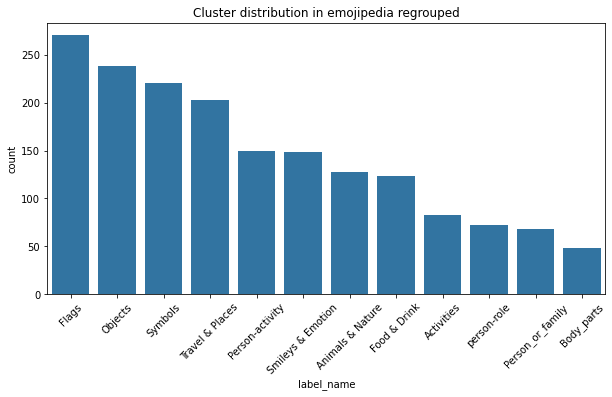

In [5]:
plt.figure(figsize = [10,5])
sb.countplot(data=improved_clusters_df,x='label_name',order=improved_clusters_df.label_name.value_counts().index,
            color=base_color)
plt.xticks(rotation=45)
plt.title('Cluster distribution in emojipedia regrouped');

#### Dictionnary label_num to label_name

In [6]:
# Building a dictionnary label_num to label_name
num_2_name = improved_clusters_df[['label_num', 'label_name']].copy()

In [7]:
num2name = num_2_name.groupby(by='label_name').first()

In [8]:
num2name

,label_num
label_name,
Activities,0
Animals & Nature,1
Body_parts,2
Flags,3
Food & Drink,4
Objects,5
Person-activity,6
Person_or_family,7
Smileys & Emotion,8


In [9]:
num_2_name_lookup = dict(zip(list(num2name.label_num),list(num2name.index)))

In [10]:
df = improved_clusters_df[["emoji_description", "label_num"]].copy()

In [11]:
df.sample(3, random_state=123)

,emoji_description,label_num
189,"A person with a serious expression,showing mil...",6
1052,A laptop personal computer. Depicted as a blac...,5
954,"A metal device, dropped out of a boat to preve...",10


In [12]:
# Taking a copy of the dataframe
dataframe = improved_clusters_df[["emoji_description", "label_num"]].copy()

In [13]:
dataframe.label_num.nunique()

12

## 1B. Data Augmentation

###  Using TextBlob

In [15]:
!python -m textblob.download_corpora

[nltk_data] Downloading package brown to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package brown is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package punkt is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package averaged_perceptron_tagger to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package averaged_perceptron_tagger is already up-to-
[nltk_data]       date!
[nltk_data] Downloading package conll2000 to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package conll2000 is already up-to-date!
[nltk_data] Downloading package movie_reviews to
[nltk_data]     /Users/elenastein/nltk_data...
[nltk_data]   Package movie_reviews is already up-to-date!
Finished.


In [16]:
from textblob import TextBlob
from textblob.translate import NotTranslated

In [17]:
def textblob_dataugm(df,name_text_col='features',name_label_col='target'):
  # Extracting a list with all the descriptions and one with the related emojis
  descr_list = list(df[name_text_col])
  label_list = list(df[name_label_col])

  corr_desc = []
  updated_label = [] # In case a NotTransalted Error would be raisen
  for i, descr in enumerate(descr_list):
    print(f'Augmenting description job: {math.ceil(((i+1)/len(label_list))*100)}%')
    clear_output(wait=True)
    blob_descr = TextBlob(descr)
    try:
        fr_descr = blob_descr.correct().translate(from_lang='en', to ='fr')
    except NotTranslated:
        print('Error with ', blob_descr)
    
    try:
        en_descr = fr_descr.translate(from_lang='fr', to='en')
        updated_label.append(label_list[i]) # Only keeping emoji if no NotTranslatedError
        corr_desc.append(str(en_descr).replace("Embolism","emoji").replace("embolism","emoji"))
    except NotTranslated:
        pass
  
  assert len(corr_desc) == len(updated_label)
    
  
  # adding old and new lists together
  new_desc_list = descr_list + corr_desc
  new_label_list = label_list + updated_label

  help_dict = {"features": new_desc_list, "target": new_label_list}
  new_df = pd.DataFrame(help_dict)

  return new_df

## 2. Dataset prepa

#### Creating a train and test dataset from a Pandas DataFrame

source : https://www.tensorflow.org/tutorials/structured_data/feature_columns

 >  Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly.

In [18]:
dataframe.sample(3)

,emoji_description,label_num
534,"A sauropod, amassive, plant-eating dinosaur wi...",1
1713,"The flag forTogo, which may show as the letter...",3
1547,"The flag for Czechia, which may show as the le...",3


In [19]:
# Updating the names of the columns
dataframe.columns = ['features','target']

In [20]:
dataframe.head(1)

,features,target
0,"A yellow face with simple, open eyes and a bro...",8


#### Dividing in Train and Test Set








In [21]:
# Dividing in train and test set WITHOUT DATA AUGMENTATION
from sklearn.model_selection import train_test_split
train, test = train_test_split(dataframe, test_size=0.2,random_state=123)

print(len(train), 'train examples')
print(len(test), 'test examples')

1401 train examples
351 test examples


#### Divinding in Train and Test Set in case of Data Augmentation

> As the data augmentation, will happen on the train set, here we take a test set that's a bit bigger 

In [22]:
# Dividing in train and test set (Not EXECUTING IF LOADING THE DATA)
#train_augm, test_30pct = train_test_split(dataframe, test_size=0.3,random_state=123) # Taking this time a bigger Test Set

#print(len(train_augm), 'train examples')
#print(len(test_30pct), 'test examples')

In [23]:
# DUBBLE THE TRAIN SET BY ADDING TRANSLATION EN-FR-EN
#train_augm = textblob_dataugm(train_augm)   # You can run it in case not possible to load the 

In [24]:
# Downloading the dataframe locally (Only first time to keep the data locally )
#from google.colab import files
#train_augm.to_csv('train_augm.csv') 
#test_30pct.to_csv('test_30pct.csv')
#files.download('train_augm.csv')
#files.download('test_30pct.csv')

In [25]:
train_augm = pd.read_csv('train_augm.csv')

In [26]:
test_30pct = pd.read_csv('test_30pct.csv')

In [27]:
# Removing first column
train_augm.drop(columns=['Unnamed: 0'],inplace=True)
test_30pct.drop(columns=['Unnamed: 0'],inplace=True)

In [28]:
print(train_augm.shape)

train_augm.sample(10,random_state=123)

(2452, 2)


,features,target
638,The Woman Standing emoji is aZWJ sequencecombi...,6
1195,The Man in Manual Wheelchair emoji is aZWJ seq...,6
556,TheAries astrological sign in the Zodiac. This...,9
1998,"A ball of yarn, used to knit a scarf. Color va...",0
1059,"Apoodle, a popular dog breed with curly hair, ...",1
1205,"CJK Ideographs are characters used in Chinese,...",9
45,"The flag forMarshall Islands, which may show a...",3
993,"A hunk of unspecified meat on a white bone, as...",4
1689,Dark cross button,9
2311,"A magnetic compass, used for navigation. Usual...",10


#### Creating an input pipeline using tf.data 

> Next, we will wrap the dataframes with tf.data. This will enable us to use feature columns as a bridge to map from the columns in the Pandas dataframe to features used to train the model. If we were working with a very large CSV file (so large that it does not fit into memory), we would use tf.data to read it from disk directly. That is not covered in this tutorial.

In [29]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batching = True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dataframe.squeeze(), labels.squeeze()))
  print(dataframe.squeeze().shape,labels.shape) # Here important to Squeez() to get t he same Size as expected
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  
  if batching:
    ds = ds.batch(batch_size)
  return ds

#### DATASETS ACTUALLY USED IN THE DIFFERENT MODELS HEREUNDER

In [30]:
# Test without the Batch => THAT WILL BE USED AS INPUT FOR THE DL MODEL (Here WITHOUT DATA AUGMENTATION)
train_ds_nbatch = df_to_dataset(train, batching=False)
test_ds_nbatch = df_to_dataset(test, batching=False)

(1401,) (1401,)
(351,) (351,)


In [31]:
# Test without the Batch => THAT WILL BE USED AS INPUT FOR THE DL MODEL (Here WITH DATA AUGMENTATION)
train_ds_nbatch_dAug = df_to_dataset(train_augm, batching=False)
test_ds_nbatch_dAug = df_to_dataset(test_30pct, batching=False)

(2452,) (2452,)
(526,) (526,)


## 3. Tensorflow Hub

source : https://www.tensorflow.org/tutorials/keras/text_classification_with_hub





In [32]:
import tensorflow_hub as hub

# 20 dimension embedding
embedding = "https://tfhub.dev/google/tf2-preview/gnews-swivel-20dim/1"
embedding_layer = hub.KerasLayer(
    embedding,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [33]:
# 128 dimensions embedding
import tensorflow_hub as hub

embedding_128D = "https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1"
embedding_layer_128D = hub.KerasLayer(
    embedding_128D,
    input_shape=[],
    dtype=tf.string,
    trainable=True
)

In [34]:
train_batch, labels_batch = next(iter(train_ds_nbatch.batch(1)))

In [35]:
train_batch

<tf.Tensor: id=381, shape=(1,), dtype=string, numpy=
array([b'A symbol forhigh voltage, as warns against injury from electricity. Depicted as a jagged yellow bolt.Commonly used to representlightning, electricity, and various flashes. Also used to represent metaphorical energy and signal attention online.Samsung\xe2\x80\x99s bolt waspreviouslywhite on a blue square, as an icon for high voltage.'],
      dtype=object)>

In [36]:
# Example applying the sentence embedding  (20 dimensions)
embedding_layer(train_batch)

<tf.Tensor: id=392, shape=(1, 20), dtype=float32, numpy=
array([[ 1.923185  ,  0.5042776 ,  0.47267556,  1.4052485 ,  0.56054044,
        -0.56401855, -0.01988679,  0.10682295, -0.3530513 , -2.5055523 ,
         0.12686963,  2.5504787 , -1.7100486 , -0.398399  ,  0.41210425,
         0.07715536,  1.0088035 , -1.4085124 , -0.878927  , -1.1599126 ]],
      dtype=float32)>

In [37]:
# Example of applying the the sentence embedding (128 dimensions)
embedding_layer_128D(train_batch)

<tf.Tensor: id=402, shape=(1, 128), dtype=float32, numpy=
array([[ 0.32882312, -0.1753728 ,  0.15609056, -0.08232294,  0.05578675,
        -0.0470325 ,  0.0114923 ,  0.03730855, -0.03000744,  0.10449489,
        -0.02264376, -0.1437109 , -0.15261379,  0.12098204,  0.09387542,
        -0.00658559, -0.21951504,  0.09509709, -0.02681251,  0.19848046,
         0.106074  ,  0.08239695,  0.05809028, -0.14611372, -0.01537213,
        -0.17920409, -0.02142115,  0.06677447,  0.04791304,  0.05938786,
         0.17675483, -0.07412416, -0.03947022, -0.15352653, -0.04502379,
         0.0115072 , -0.01542679, -0.23209232, -0.03930252,  0.08313219,
         0.02279996,  0.11712153, -0.1285536 ,  0.05118829,  0.22735894,
        -0.05561684, -0.03705078, -0.00804429,  0.08880356, -0.12334981,
         0.16295654,  0.08333899, -0.10648666,  0.10936991,  0.00427306,
         0.10631455,  0.03471667,  0.07290221,  0.17366663,  0.0641716 ,
         0.06262796,  0.02260457, -0.05888784, -0.11274834, -0.147

### Building the Multi-class classification Model

#### Data Variables

In [38]:
# Data WITOUT DATA AUGMENTATION
train_data = train_ds_nbatch
test_data = test_ds_nbatch

In [39]:
# Data WITH DATA AUGMENTATION
train_data_augm = train_ds_nbatch_dAug
test_data_augm = test_ds_nbatch_dAug

In [40]:
# To be used to build the confusion matrix
test_conf, test_labels_conf = next(iter(test_ds_nbatch.batch(351)))

In [41]:
# To be used to build the confusion matrix
test_conf_augm, test_labels_conf_augm = next(iter(test_data_augm.batch(526)))

#### Prepa data 


In [42]:
# A utility method to create a tf.data dataset from a Pandas Dataframe
def df_to_dataset(dataframe, shuffle=True, batching = True, batch_size=32):
  dataframe = dataframe.copy()
  labels = dataframe.pop('target')
  ds = tf.data.Dataset.from_tensor_slices((dataframe.squeeze(), labels.squeeze()))
  print(dataframe.squeeze().shape,labels.shape) # Here important to Squeez() to get the same Size as expected
  if shuffle:
    ds = ds.shuffle(buffer_size=len(dataframe))
  
  if batching:
    ds = ds.batch(batch_size)
  return ds

In [43]:
def sentence_to_dataset(sentence):
  # Creating a DataFrame
  list_sentences = [sentence]
  df = pd.DataFrame(list_sentences, columns=['sentence'])
  ds = tf.data.Dataset.from_tensor_slices(df)

  return ds


In [44]:
def predict4_one_sentence(sentence, model):
  ds = sentence_to_dataset(sentence)
  pred = model.predict(ds)
  cat_num = np.argmax(pred)
  pred_cluster = num_2_name_lookup[cat_num]
  
  return pred_cluster

In [45]:
def predict4_tfdataset(test_features, test_labels, model):
  # making the predictions on the given dataset
  predictions = model.predict(test_features)
  # converting the feateres and test_labels dataset to a numpy array
  features_2_numpy = tfds.as_numpy(test_features, graph=None)
  labels_2_numpy = tfds.as_numpy(test_labels, graph=None)

  # Looping over the predictions and real labels
  for i,pred in enumerate(predictions):
    # finding back the category
    pred_cluster = num_2_name_lookup[np.argmax(pred)]
    real_cluster = num_2_name_lookup[labels_2_numpy[i]]
    print(f'The sentence is : {features_2_numpy[i]}')
    print(f'The REAL CATEGORY is : {real_cluster} versus the PREDICTED CATEGORY : {pred_cluster}')
    print("")



In [46]:
# confusion matrix
from sklearn.metrics import confusion_matrix

def multiclass_confusion_mat(test_features, test_labels, model):
  # making the predictions on the given dataset
  pred_proba = model.predict(test_features)
  predictions = np.argmax(pred_proba, axis=1) # prediction = arg of max proba

  # converting the test_labels dataset to a numpy array
  labels_2_numpy = tfds.as_numpy(test_labels, graph=None)

  plt.figure(figsize = [10,10])
  cf_matrix = confusion_matrix(labels_2_numpy, predictions)
  sb.heatmap(cf_matrix/np.sum(cf_matrix), annot=True, fmt='.2%', cmap='Blues')
  plt.xlabel("Predicted Labels")
  plt.ylabel("Real Labels")

In [47]:
def plot_history(history):
  plt.plot(history.history["loss"], label="loss")
  plt.plot(history.history["val_loss"], label="val_loss")
  plt.legend()
  plt.show()
  plt.close()

  plt.plot(history.history["accuracy"], label="accuracy")
  plt.plot(history.history["val_accuracy"], label="val_accuracy")
  plt.legend()
  plt.show()
  plt.close()

In [48]:
test

,features,target
189,"A person with a serious expression,showing mil...",6
1052,A laptop personal computer. Depicted as a blac...,5
954,"A metal device, dropped out of a boat to preve...",10
472,"The face of aunicorn, a mythical creature in t...",1
147,A mechanical or prosthetic leg.Mechanical Legw...,2
...,...,...
1636,"The flag for St. Martin, which may show as the...",3
169,The Man: Curly Hair emoji is aZWJ sequencecomb...,7
1541,"The flag for Costa Rica, which may show as the...",3
489,"A giraffe, the tallest animal on Earth, with s...",1


#### A. Base Model


In [49]:
# Setting up Early Stopping
from tensorflow.keras.callbacks import EarlyStopping

# Creating an early stopping object early_stopping 
custom_early_stopping = EarlyStopping(
    monitor='val_accuracy', 
    patience=5, 
    min_delta=0.001, 
    mode='auto'
)

**EarlyStopping() has a few options and by default:**
> - _monitor='val_loss':_ 
> 
>> to use validation loss as performance measure to terminate the training.
> - _patience=0:_ 
> 
>> is the number of epochs with no improvement. The value 0 means the training is terminated as soon as the performance measure gets worse from one epoch to the next.
> 
> - _min_delta:_ 
>
>> Minimum change in the monitored quantity to qualify as an improvement, i.e. an absolute change of less than min_delta, will count as no improvement.
> 
>-  _mode='auto':_
> 
>> Should be one of auto, min or max. In 'min' mode, training will stop when the quantity monitored has stopped decreasing; in 'max' mode it will stop when the quantity monitored has stopped increasing; in 'auto' mode, the direction is automatically inferred from the name of the monitored quantity.

##### I. WITHOUT DATA AUGMENTATION

In [50]:
base_model = models.Sequential()
base_model.add(embedding_layer)
base_model.add(layers.Dense(100, activation="relu"))
base_model.add(layers.Dense(12, activation="softmax"))
base_model.summary()

base_model.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense (Dense)                (None, 100)               2100      
_________________________________________________________________
dense_1 (Dense)              (None, 12)                1212      
Total params: 403,332
Trainable params: 403,332
Non-trainable params: 0
_________________________________________________________________


In [51]:
base_history = base_model.fit(
    train_data.cache().batch(32),
    epochs=50,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/50
44/44 [==============================] - 2s 35ms/step - loss: 2.1263 - accuracy: 0.2748 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
44/44 [==============================] - 0s 8ms/step - loss: 1.6243 - accuracy: 0.4925 - val_loss: 1.4666 - val_accuracy: 0.5442
Epoch 3/50
44/44 [==============================] - 0s 8ms/step - loss: 1.3761 - accuracy: 0.5753 - val_loss: 1.2966 - val_accuracy: 0.5869
Epoch 4/50
44/44 [==============================] - 0s 8ms/step - loss: 1.2020 - accuracy: 0.6288 - val_loss: 1.1789 - val_accuracy: 0.6125
Epoch 5/50
44/44 [==============================] - 0s 8ms/step - loss: 1.0621 - accuracy: 0.6717 - val_loss: 1.0907 - val_accuracy: 0.6353
Epoch 6/50
44/44 [==============================] - 0s 8ms/step - loss: 0.9436 - accuracy: 0.7131 - val_loss: 1.0237 - val_accuracy: 0.6724
Epoch 7/50
44/44 [==============================] - 0s 8ms/step - loss: 0.8397 - accuracy: 0.7566 - val_loss: 0.9674 - val_accuracy: 0.7094
Epoch 8/50


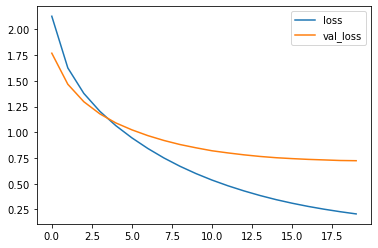

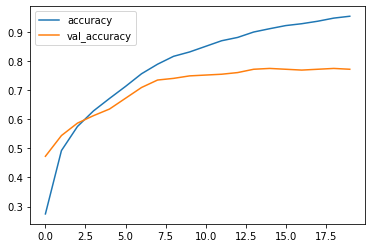

In [52]:
plot_history(base_history)

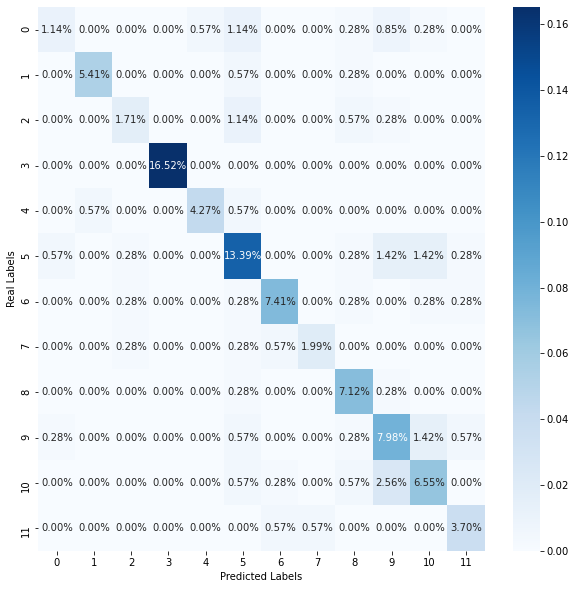

In [53]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model)

In [54]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [55]:
predict4_tfdataset(test_batch, test_labels_batch, base_model)

The sentence is : b"A blue or black ballpoint pen, as used for everyday writing. Depicted with its cap removed onto its end or as retractable pen. Positioned at a 45\xc2\xb0 angle, its tip at the lower left. Commonly used for various content concerning writing (e.g., creative, professional) as well as signing (deals, laws, in sports).Google's designpreviously featureda brown-colored pen. Not to be confused with\xe2\x9c\x92\xef\xb8\x8fBlack Nibor\xf0\x9f\x96\x8b\xef\xb8\x8fFountain Pen, though their applications often overlap."
The REAL CATEGORY is : Objects versus the PREDICTED CATEGORY : Objects

The sentence is : b'The Woman Firefighter emoji is aZWJ sequencecombining\xf0\x9f\x91\xa9Woman,\xe2\x80\x8dZero Width Joinerand\xf0\x9f\x9a\x92Fire Engine.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : person-role versus the PREDICTED CATEGORY : person-role

The sentence is : b'The flag forMexico, which may show as the lettersMXon some platforms.The Flag: Me

##### II. WITH DATA AUGMENTATION

In [56]:
base_model_augm = models.Sequential()
base_model_augm.add(embedding_layer)
base_model_augm.add(layers.Dense(100, activation="relu"))
base_model_augm.add(layers.Dense(12, activation="softmax"))
base_model_augm.summary()

base_model_augm.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

Model: "sequential_1"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer (KerasLayer)     (None, 20)                400020    
_________________________________________________________________
dense_2 (Dense)              (None, 100)               2100      
_________________________________________________________________
dense_3 (Dense)              (None, 12)                1212      
Total params: 403,332
Trainable params: 403,332
Non-trainable params: 0
_________________________________________________________________


In [57]:
base_history_augm = base_model_augm.fit(
    train_data_augm.cache().batch(32),
    epochs=50,
    validation_data=test_data_augm.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/50
77/77 [==============================] - 2s 20ms/step - loss: 1.7462 - accuracy: 0.5029 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/50
77/77 [==============================] - 1s 8ms/step - loss: 0.9476 - accuracy: 0.7659 - val_loss: 0.8686 - val_accuracy: 0.7605
Epoch 3/50
77/77 [==============================] - 1s 8ms/step - loss: 0.6201 - accuracy: 0.8495 - val_loss: 0.7049 - val_accuracy: 0.8004
Epoch 4/50
77/77 [==============================] - 1s 8ms/step - loss: 0.4530 - accuracy: 0.8972 - val_loss: 0.6262 - val_accuracy: 0.8194
Epoch 5/50
77/77 [==============================] - 1s 8ms/step - loss: 0.3530 - accuracy: 0.9188 - val_loss: 0.5769 - val_accuracy: 0.8232
Epoch 6/50
77/77 [==============================] - 1s 7ms/step - loss: 0.2858 - accuracy: 0.9323 - val_loss: 0.5540 - val_accuracy: 0.8270
Epoch 7/50
77/77 [==============================] - 1s 8ms/step - loss: 0.2371 - accuracy: 0.9437 - val_loss: 0.5225 - val_accuracy: 0.8308
Epoch 8/50


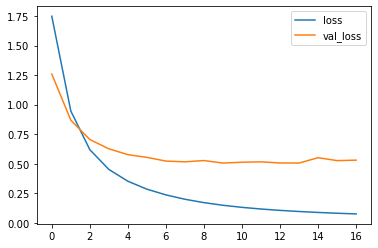

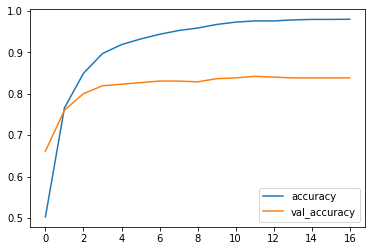

In [58]:
plot_history(base_history_augm)

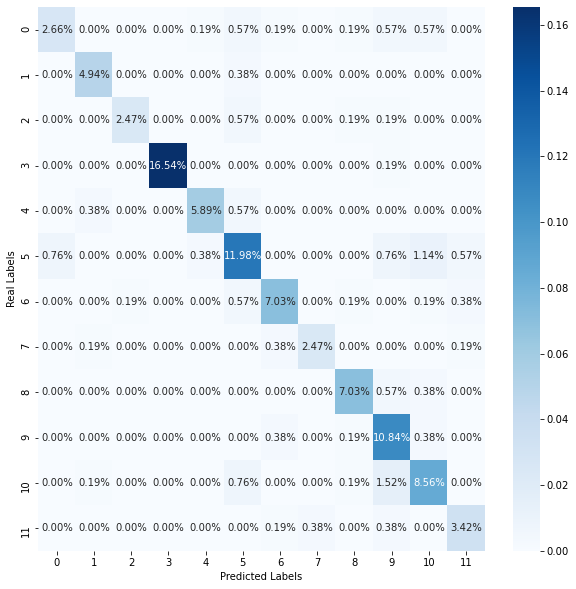

In [59]:
multiclass_confusion_mat(test_conf_augm, test_labels_conf_augm, base_model_augm)

In [60]:
# TAKING A BATCH of the TEST DATA
test_batch_augm, test_labels_batch_augm = next(iter(test_ds_nbatch_dAug.shuffle(300).batch(10)))

In [61]:
predict4_tfdataset(test_batch_augm, test_labels_batch_augm, base_model_augm)

The sentence is : b'A swan, a waterbird with white feathers and a long neck. Depicted in full profile facing left, with a curving neck, orange bill, black eye marking, and wings and legs tucked in, as if gliding in water.May be used to represent a goose or, metaphorically, love, grace, and beauty.'
The REAL CATEGORY is : Animals & Nature versus the PREDICTED CATEGORY : Animals & Nature

The sentence is : b'Thin-cut, golden-brown French fries, served in a red carton, as at McDonald\xe2\x80\x99s. Apple featuresSmiling Face With Smiling Eyeson its carton.'
The REAL CATEGORY is : Food & Drink versus the PREDICTED CATEGORY : Food & Drink

The sentence is : b'A yellow face with a broad, open smile, showing upper teeth on most platforms, with stars for eyes, as if seeing a beloved celebrity. Color of stars widely varies by platform, though commonly gold or red. May express that someone or something is amazing, fascinating, impressive, or exciting.'
The REAL CATEGORY is : Smileys & Emotion ver

#### B. BASE_MODEL but with EMBEDDINLAYER Dimension 128D

##### I. Without Regularization

In [62]:
base_model_128D = models.Sequential()
base_model_128D.add(embedding_layer_128D)
base_model_128D.add(layers.Dense(100, activation="relu"))
base_model_128D.add(layers.Dense(12, activation="softmax"))
base_model_128D.summary()

base_model_128D.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

base_history_128D = base_model_128D.fit(
    train_data.cache().batch(32),
    epochs=15,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)


Model: "sequential_2"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_4 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_5 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/15
44/44 [==============================] - 43s 980ms/step - loss: 2.1150 - accuracy: 0.3597 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/15
44/44 [==============================] - 39s 891ms/step - loss: 1.3888 - accuracy: 0.6838 - val_loss: 1.1949 - val_accuracy: 0.6980
Epoch 3/15
44/44 [==============================] - 40s 901ms/step - loss: 0

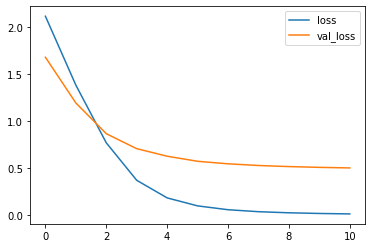

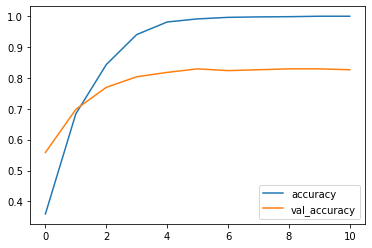

In [63]:
plot_history(base_history_128D)

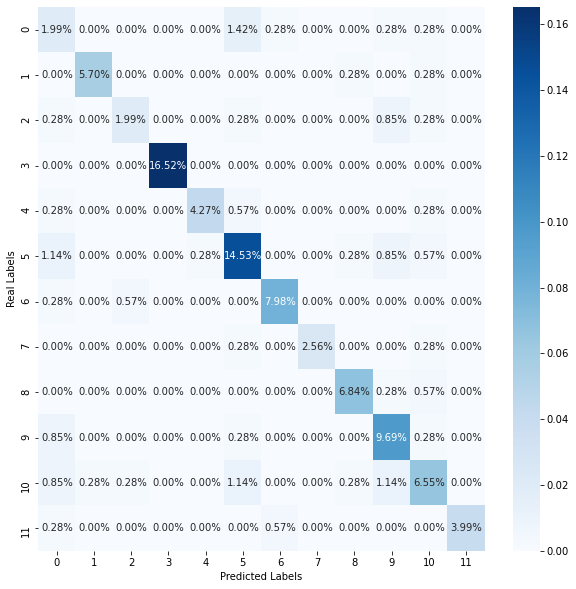

In [64]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D)

In [65]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [66]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D)

The sentence is : b'Nine O\xe2\x80\x99Clock'
The REAL CATEGORY is : Travel & Places versus the PREDICTED CATEGORY : Travel & Places

The sentence is : b'The Flag: South Georgia & South Sandwich Islands emoji is aflag sequencecombining\xf0\x9f\x87\xacRegional Indicator Symbol Letter Gand\xf0\x9f\x87\xb8Regional Indicator Symbol Letter S.\nThese display as a single emoji on supported platforms.'
The REAL CATEGORY is : Flags versus the PREDICTED CATEGORY : Flags

The sentence is : b'A friendly, cartoon-styled face of a monkey, looking straight ahead. Depicted as a brown-haired monkey with a tan or pinkish face, round ears, nostrils, and open-mouthed smile.As with the full-bodied\xf0\x9f\x90\x92 Monkey, often used with a playful tone or for metaphorical senses ofmonkey.One of the 12 animals of theChinese zodiac. Available as an AppleAnimoji.Vendors implement the sameor similar monkey face in their Three Wise Monkeys emojis:\xf0\x9f\x99\x88 See-No-Evil Monkey,\xf0\x9f\x99\x89 Hear-No-Evil M

II. With Regularization

In [67]:
# hyperparameters:
factor = 0.001
rate =  0.3

##### 1. Only L2 Regularization

In [68]:
base_model_128D_l2 = models.Sequential()
base_model_128D_l2.add(embedding_layer_128D)
base_model_128D_l2.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_l2.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_l2.summary()

base_model_128D_l2.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

base_history_128D_l2 = base_model_128D_l2.fit(
    train_data.cache().batch(32),
    epochs=12,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)


Model: "sequential_3"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dense_6 (Dense)              (None, 100)               12900     
_________________________________________________________________
dense_7 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________
Epoch 1/12
44/44 [==============================] - 43s 969ms/step - loss: 1.8830 - accuracy: 0.5625 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/12
44/44 [==============================] - 39s 894ms/step - loss: 0.8547 - accuracy: 0.8972 - val_loss: 0.9983 - val_accuracy: 0.7835
Epoch 3/12
44/44 [==============================] - 37s 847ms/step - loss: 0

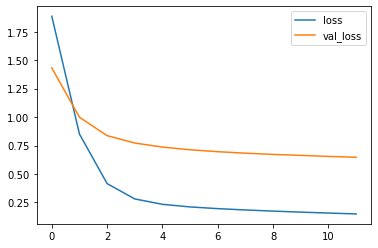

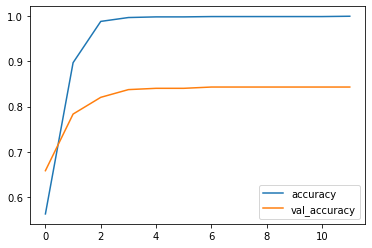

In [69]:
plot_history(base_history_128D_l2)

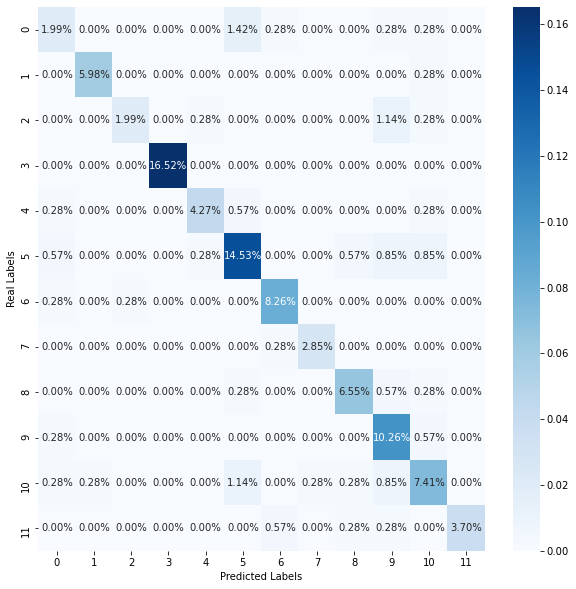

In [70]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D_l2)

In [71]:
# TAKING A BATCH of the TEST DATA
test_batch, test_labels_batch = next(iter(test_ds_nbatch.batch(10)))

In [72]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_l2)

The sentence is : b'A classic spider web (cobweb), as spun by a\xf0\x9f\x95\xb7\xef\xb8\x8f Spiderto catch prey. Depicted as a white, symmetrical, wheel-shaped web, as anorb web,with six or eight equal sectors.Commonly used during Halloween, to represent the superheroSpider-Man, or for a metaphorical web, net, or network. Not to be confused with\xe2\x9d\x84\xef\xb8\x8f Snowflake.'
The REAL CATEGORY is : Animals & Nature versus the PREDICTED CATEGORY : Travel & Places

The sentence is : b'A bone which may be used for a dog to chew on, or as a part of the human body. The type of bone is not specified.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Body_parts

The sentence is : b'A golden-brown, crescent-shaped, vanilla-flavored fortune cookie. Usually depicted with a strip of paper\xe2\x80\x94on which a wise saying, lucky numbers, orChinesevocabulary is written\xe2\x80\x94peaking out of its hollow shell. Given at the end of meals at Chinese restaurants in the West.'
T

#### 2. L2 and Dropout with EarlyStopping

In [73]:
base_model_128D_reg = models.Sequential()
base_model_128D_reg.add(embedding_layer_128D)
base_model_128D_reg.add(layers.Dropout(rate))
base_model_128D_reg.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg.add(layers.Dropout(rate))
base_model_128D_reg.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg.summary()

base_model_128D_reg.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])



Model: "sequential_4"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout (Dropout)            (None, 128)               0         
_________________________________________________________________
dense_8 (Dense)              (None, 100)               12900     
_________________________________________________________________
dropout_1 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_9 (Dense)              (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________


In [74]:
# Applying Early Stopping
base_history_128D_reg = base_model_128D_reg.fit(
    train_data.cache().batch(32),
    epochs=30,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/30
44/44 [==============================] - 44s 1s/step - loss: 1.9134 - accuracy: 0.5346 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
44/44 [==============================] - 45s 1s/step - loss: 0.8857 - accuracy: 0.8901 - val_loss: 0.9635 - val_accuracy: 0.8034
Epoch 3/30
44/44 [==============================] - 40s 918ms/step - loss: 0.4662 - accuracy: 0.9672 - val_loss: 0.8055 - val_accuracy: 0.8319
Epoch 4/30
44/44 [==============================] - 38s 864ms/step - loss: 0.3111 - accuracy: 0.9893 - val_loss: 0.7435 - val_accuracy: 0.8319
Epoch 5/30
44/44 [==============================] - 43s 979ms/step - loss: 0.2583 - accuracy: 0.9964 - val_loss: 0.7095 - val_accuracy: 0.8348
Epoch 6/30
44/44 [==============================] - 42s 949ms/step - loss: 0.2277 - accuracy: 0.9964 - val_loss: 0.6917 - val_accuracy: 0.8319
Epoch 7/30
44/44 [==============================] - 39s 885ms/step - loss: 0.2143 - accuracy: 0.9986 - val_loss: 0.6750 - val_accuracy: 0.83

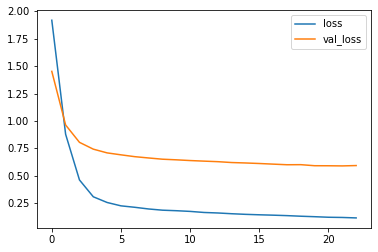

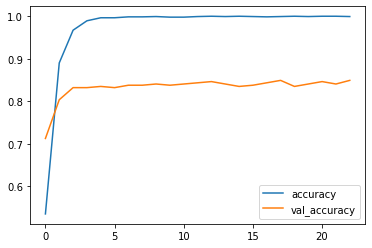

In [75]:
plot_history(base_history_128D_reg)

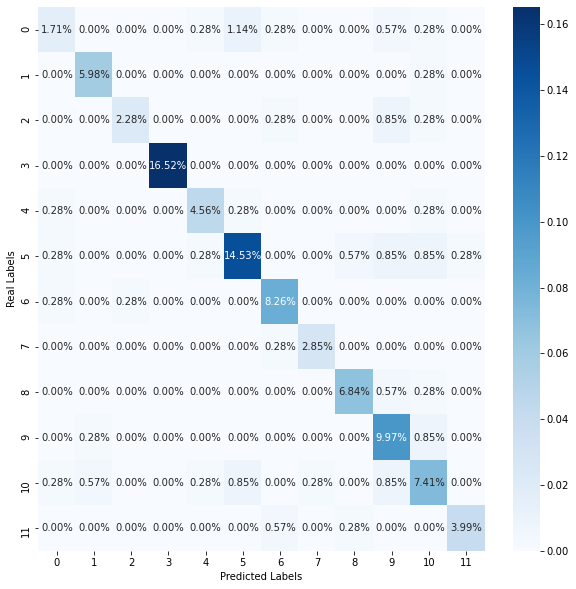

In [76]:
multiclass_confusion_mat(test_conf, test_labels_conf, base_model_128D_reg)

In [77]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg)

The sentence is : b'A classic spider web (cobweb), as spun by a\xf0\x9f\x95\xb7\xef\xb8\x8f Spiderto catch prey. Depicted as a white, symmetrical, wheel-shaped web, as anorb web,with six or eight equal sectors.Commonly used during Halloween, to represent the superheroSpider-Man, or for a metaphorical web, net, or network. Not to be confused with\xe2\x9d\x84\xef\xb8\x8f Snowflake.'
The REAL CATEGORY is : Animals & Nature versus the PREDICTED CATEGORY : Travel & Places

The sentence is : b'A bone which may be used for a dog to chew on, or as a part of the human body. The type of bone is not specified.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Body_parts

The sentence is : b'A golden-brown, crescent-shaped, vanilla-flavored fortune cookie. Usually depicted with a strip of paper\xe2\x80\x94on which a wise saying, lucky numbers, orChinesevocabulary is written\xe2\x80\x94peaking out of its hollow shell. Given at the end of meals at Chinese restaurants in the West.'
T

##### I. WITH DATA AUGMENTATION

In [78]:
base_model_128D_reg_augm = models.Sequential()
base_model_128D_reg_augm.add(embedding_layer_128D)
base_model_128D_reg_augm.add(layers.Dropout(rate))
base_model_128D_reg_augm.add(layers.Dense(100,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg_augm.add(layers.Dropout(rate))
base_model_128D_reg_augm.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg_augm.summary()

base_model_128D_reg_augm.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])


Model: "sequential_5"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout_2 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_10 (Dense)             (None, 100)               12900     
_________________________________________________________________
dropout_3 (Dropout)          (None, 100)               0         
_________________________________________________________________
dense_11 (Dense)             (None, 12)                1212      
Total params: 124,656,800
Trainable params: 124,656,800
Non-trainable params: 0
_________________________________________________________________


In [79]:
# Applying Early Stopping
base_history_128D_reg_augm = base_model_128D_reg_augm.fit(
    train_data_augm.cache().batch(32),
    epochs=30,
    validation_data=test_data_augm.batch(32),
    callbacks=[custom_early_stopping]
)

Epoch 1/30
77/77 [==============================] - 68s 889ms/step - loss: 1.4147 - accuracy: 0.6896 - val_loss: 0.0000e+00 - val_accuracy: 0.0000e+00
Epoch 2/30
77/77 [==============================] - 69s 900ms/step - loss: 0.4848 - accuracy: 0.9474 - val_loss: 0.5483 - val_accuracy: 0.8916
Epoch 3/30
77/77 [==============================] - 69s 892ms/step - loss: 0.3357 - accuracy: 0.9686 - val_loss: 0.4971 - val_accuracy: 0.8954
Epoch 4/30
77/77 [==============================] - 63s 817ms/step - loss: 0.2727 - accuracy: 0.9800 - val_loss: 0.4768 - val_accuracy: 0.8973
Epoch 5/30
77/77 [==============================] - 63s 820ms/step - loss: 0.2433 - accuracy: 0.9845 - val_loss: 0.4816 - val_accuracy: 0.9011
Epoch 6/30
77/77 [==============================] - 62s 809ms/step - loss: 0.2197 - accuracy: 0.9890 - val_loss: 0.4655 - val_accuracy: 0.9030
Epoch 7/30
77/77 [==============================] - 63s 815ms/step - loss: 0.2064 - accuracy: 0.9910 - val_loss: 0.4425 - val_accuracy

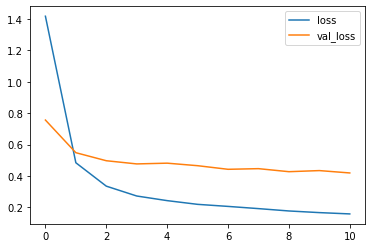

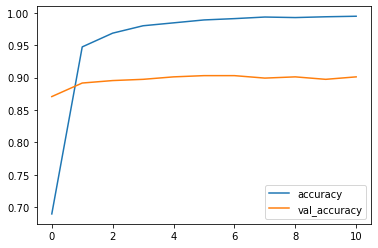

In [80]:
plot_history(base_history_128D_reg_augm)

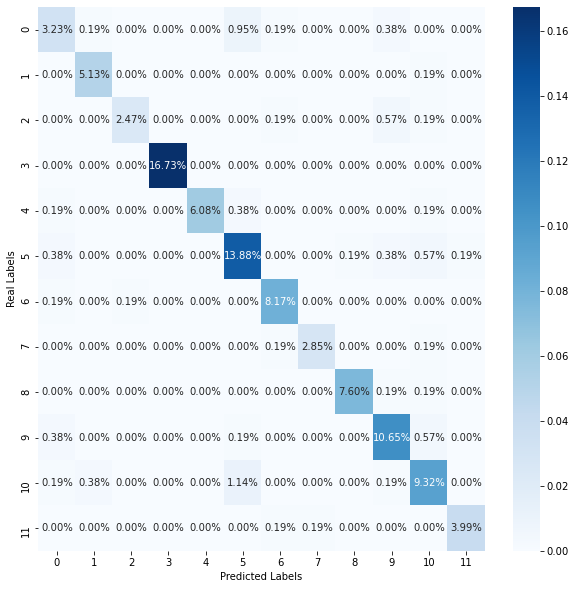

In [81]:
multiclass_confusion_mat(test_conf_augm, test_labels_conf_augm, base_model_128D_reg_augm)

In [82]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg)

The sentence is : b'A classic spider web (cobweb), as spun by a\xf0\x9f\x95\xb7\xef\xb8\x8f Spiderto catch prey. Depicted as a white, symmetrical, wheel-shaped web, as anorb web,with six or eight equal sectors.Commonly used during Halloween, to represent the superheroSpider-Man, or for a metaphorical web, net, or network. Not to be confused with\xe2\x9d\x84\xef\xb8\x8f Snowflake.'
The REAL CATEGORY is : Animals & Nature versus the PREDICTED CATEGORY : Travel & Places

The sentence is : b'A bone which may be used for a dog to chew on, or as a part of the human body. The type of bone is not specified.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Body_parts

The sentence is : b'A golden-brown, crescent-shaped, vanilla-flavored fortune cookie. Usually depicted with a strip of paper\xe2\x80\x94on which a wise saying, lucky numbers, orChinesevocabulary is written\xe2\x80\x94peaking out of its hollow shell. Given at the end of meals at Chinese restaurants in the West.'
T

#### II. Trying with less units in the Dense Layer as still overfitting

In [83]:
base_model_128D_reg_less = models.Sequential()
base_model_128D_reg_less.add(embedding_layer_128D)
base_model_128D_reg_less.add(layers.Dropout(rate))
# REDUCING THE AMOUNT OF UNITS IN HIDDEN LAYER
base_model_128D_reg_less.add(layers.Dense(40,kernel_regularizer=l2(factor) ,activation="relu"))
base_model_128D_reg_less.add(layers.Dropout(rate))
base_model_128D_reg_less.add(layers.Dense(12,kernel_regularizer=l2(factor) ,activation="softmax"))
base_model_128D_reg_less.summary()

base_model_128D_reg_less.compile(
    optimizer="adam", 
    loss='sparse_categorical_crossentropy',
    metrics=["accuracy"])

# Applying Early Stopping
base_history_128D_reg_less = base_model_128D_reg_less.fit(
    train_data.cache().batch(32),
    epochs=30,
    validation_data=test_data.batch(32),
    callbacks=[custom_early_stopping]
)

Model: "sequential_6"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
keras_layer_1 (KerasLayer)   (None, 128)               124642688 
_________________________________________________________________
dropout_4 (Dropout)          (None, 128)               0         
_________________________________________________________________
dense_12 (Dense)             (None, 40)                5160      
_________________________________________________________________
dropout_5 (Dropout)          (None, 40)                0         
_________________________________________________________________
dense_13 (Dense)             (None, 12)                492       
Total params: 124,648,340
Trainable params: 124,648,340
Non-trainable params: 0
_________________________________________________________________
Epoch 1/30
44/44 [==============================] - 36s 826ms/step - loss: 1.9241 - accuracy: 0.4554 - val

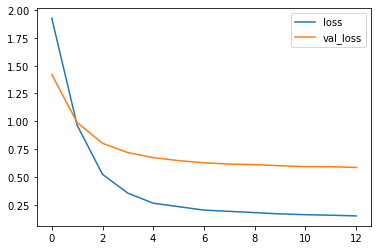

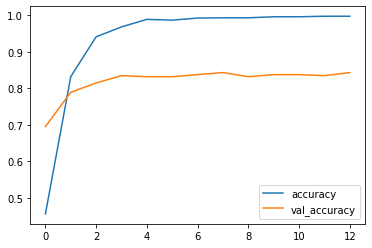

In [84]:
plot_history(base_history_128D_reg_less)

In [85]:
predict4_tfdataset(test_batch, test_labels_batch, base_model_128D_reg_less)

The sentence is : b'A classic spider web (cobweb), as spun by a\xf0\x9f\x95\xb7\xef\xb8\x8f Spiderto catch prey. Depicted as a white, symmetrical, wheel-shaped web, as anorb web,with six or eight equal sectors.Commonly used during Halloween, to represent the superheroSpider-Man, or for a metaphorical web, net, or network. Not to be confused with\xe2\x9d\x84\xef\xb8\x8f Snowflake.'
The REAL CATEGORY is : Animals & Nature versus the PREDICTED CATEGORY : Travel & Places

The sentence is : b'A bone which may be used for a dog to chew on, or as a part of the human body. The type of bone is not specified.'
The REAL CATEGORY is : Body_parts versus the PREDICTED CATEGORY : Body_parts

The sentence is : b'A golden-brown, crescent-shaped, vanilla-flavored fortune cookie. Usually depicted with a strip of paper\xe2\x80\x94on which a wise saying, lucky numbers, orChinesevocabulary is written\xe2\x80\x94peaking out of its hollow shell. Given at the end of meals at Chinese restaurants in the West.'
T